<a href="https://colab.research.google.com/github/PavanDaniele/drone-person-detection/blob/main/model_Training_and_Evaluation_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up: mount drive + import libraries

**Important Information:** We need to activate the GPU on Colab (_Runtime --> Change runtime type_). \
Every time you start a new session (or reopen the notebook after a few hours) check that the GPU is still active. If we are not using the GPU it can take up to tens of hours to train the models. \
_GPU T4 is the best choice._

In [1]:
# Run this Every time you start a new session
from google.colab import drive
drive.mount('/content/drive') # to mount google drive (to see/access it)

Mounted at /content/drive


In [2]:
!pip install ultralytics # Installation of Ultralytics for YOLO models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.6 MB/s eta 0:00:00


In [33]:
!pip -q install plotly pandas

In [3]:
from ultralytics import YOLO # Import of Ultralytics for YOLO models

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [78]:
import shutil
import os
from PIL import Image
import numpy as np
import pandas as pd

import torch
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
import plotly.express as px

import re
import yaml

# General Explanation

### Backbone

In Computer Vision, a _Backbone_ is the part of a convolutional neural network responsible for extracting the main features from an image. \
It serves as the shared base upon which subsequent modules are built (such as heads for classification, object detection, segmentation, etc.).

\
Each backbone has been pre-trained on specific datasets (e.g., ImageNet) using particular preprocessing steps, input dimensions, normalization, and augmentation techniques, which should ideally be replicated during fine-tuning to maintain compatibility and achieve optimal performance.

### Data Loader

To train a deep learning model, it is essential to properly handle data loading and preparation. This is the task of the _Data Loader_, a component responsible for:
- Loading images and their corresponding annotations (e.g., .txt or .json) from the dataset.
- Applying preprocessing operations, such as resizing, normalization, data augmentation, etc.
- Organizing data into batches to feed the model during training.

\
Considering the limited resources of my development environment, at first I decided to perform the image and annotation resizing in a separate phase (prior to training), in order to:
- Reduce the workload of the data loader during fine-tuning;
- Increase data loading and training speed;
- Ensure consistency between images and annotations.

But due to the different type of scaling technique, I want to try to fine-tuning the model without any pre-scaling.

The other transformations, instead, are handled by the model-specific data loader, since each model uses different preprocessing and normalization techniques. \
Moreover, some models require specific transformations to achieve optimal performance, and the libraries that provide the models (e.g., Ultralytics for YOLO) already implement loaders that are properly configured and optimized.

### Normalization

Image normalization consists in scaling pixel values from the range [0, 255] to a more suitable interval (e.g., [0, 1] or [-1, 1]), often based on the mean and standard deviation of the pre-training dataset, with the goal of:
- Avoiding overly large values in the tensors;
- Making the model more stable during training;
- Speeding up convergence.

\
Normalization helps maintain a consistent pixel range and distribution, which is essential for pre-trained models.

### Data Augmentations

Data augmentation consists of random transformations (e.g., rotations, flips, crops, brightness changes, etc.) applied during training. Their purpose is to:
- Simulate new visual conditions;
- Increase dataset variety;
- Reduce overfitting by improving the model’s ability to generalize.

\
In practice, the semantic content of the image doesn't change (e.g., a person remains a person), but its visual appearance is altered to help the model "learn better."


My goal is to evaluate the real-world performance of each model in its ideal scenario, in order to select the most suitable one for deployment on the Jetson Nano. \
For this reason, each model is trained using its native augmentations, meaning the ones that were designed and optimized as part of its original architecture. \
It wouldn’t make sense to disable them or enforce a uniform setup across models, because what we want to observe is the maximum potential of each model, working in the way it was designed to perform best.

# Fine-Tuning Model

### YOLOv8n

First of all we need to save the dataset locally, for faster I/O:

In [11]:
src_yolov8n = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n'
dst_yolov8n = '/content/AERALIS_YOLOv8n_local'  # is now on the local VM, NOT on drive

# If the destination folder already exists, I delete it
if os.path.exists(dst_yolov8n):
  shutil.rmtree(dst_yolov8n)

# Recursive copy of ENTIRE folder (and subfolders)
shutil.copytree(src_yolov8n, dst_yolov8n)
print("Copy completed:", os.path.exists(dst_yolov8n))

Copy completed: True


Let's check the total free space:

In [6]:
!df -h / # It shows the total, used and free space on the root (/) of the Colab VM.

# Avail column: space still available for your files.

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   52G   61G  47% /


In [7]:
# Show space used by your local folder
!du -sh /content/AERALIS_YOLOv8n_local

6.5G	/content/AERALIS_YOLOv8n_local


In [8]:
# Show space occupied by various folders in /content/.
!du -h --max-depth=1 /content/

140K	/content/.config
6.5G	/content/AERALIS_YOLOv8n_local
du: cannot access '/content/drive/.Encrypted/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV': No such file or directory
56G	/content/drive
55M	/content/sample_data
62G	/content/


We want to create the data.yaml file, which YOLO uses to know:
- the path to the training, validation, and test images
- the number of classes (nc)
- the names of the classes (names)

\
This file is used by YOLO to locate the images and their annotations.

In [13]:
# YAML dataset (edit routes)
data_yaml_yolov8n = """
train: /content/AERALIS_YOLOv8n_local/train/images
val:   /content/AERALIS_YOLOv8n_local/val/images
test:  /content/AERALIS_YOLOv8n_local/test/images

nc: 1
names: ['person']
"""

with open('data.yaml', 'w') as f:
  f.write(data_yaml_yolov8n)

Perfect, we have correctly written the data.yaml file for the AERALIS_YOLOv8n dataset. Let's continue with the loading of the model:

In [10]:
# Upload the pre-trained model we want to use as a starting point

model_YOLOv8n = YOLO('yolov8n.pt') # it is the model that will be fine-tuned on the custom dataset

We have now downloaded the pre-trained model from the official Ultralytics repository.

In [14]:
# To see the available GPU
print(torch.cuda.is_available()) # True = you have GPU --> if False then use device='cpu'

if torch.cuda.is_available():
  print("GPU name:", torch.cuda.get_device_name(0)) # Name of GPU

# If True and at least 1, you can use device=0.
# If you don't have GPU: use device='cpu' (much slower).
# Locally (not Colab): check with nvidia-smi from terminal.

True
GPU name: NVIDIA L4


Now that we have confirmation that the GPU is active.

Training setup (YOLOv8n / YOLOv11n)

- **Batch size**: number of images processed in parallel per training step.  
  On Colab **L4 (24GB)** we use **batch=24** at imgsz=640 for higher throughput.  
  _Note: Ultralytics scales the optimizer to an effective batch via gradient accumulation, so changing 'batch' mainly affects speed, not the optimization regime. Inference on Jetson Nano will run with **batch=1**, so this does **not** affect runtime FPS on Nano._

- **Image size (imgsz=640)**: standard YOLO size for good accuracy. We will later re-check accuracy vs. imgsz=512/416 to simulate Nano’s FPS/latency trade-off.

- **Early stopping (patience=20)**: stops when the validation metrics plateau to save time and prevent overfitting.

- **Workers (workers=2)**: dataloader parallelism. On Colab this is a safe value; increase only if stable (I/O can become a bottleneck).

- **Device**: GPU index 0. AMP (mixed precision) is enabled by default by Ultralytics, improving speed and memory footprint.

- **Reproducibility**: seed=42 and deterministic=True reduce run-to-run variance (CUDA/AMP may still introduce minor non-determinism).

- **Single class**: model head adapted to **1 class (person)** (Ultralytics prints “Overriding nc=80 with nc=1”).

- **Outputs**: Ultralytics writes each run to runs_finetune/< run_name>/, including weights/{best.pt,last.pt}, results.csv, and training plots. We copy best.pt to Google Drive for persistence.

In [12]:
# Fine‑tuning
results_YOLOv8n = model_YOLOv8n.train(
  data='data.yaml', # use the newly created yaml file
  epochs=100, # Maximum number of training epochs
  imgsz=640, # Image input size (recommended for YOLO).
  batch=24,  # Batch size
  patience=20, # Early stopping if the metrics do not improve for 20 epochs
  workers=2, # Number of workers for the dataloader
  device=0, # Use GPU 0 (or put 'cpu' if you don't have GPU)
  # device='cpu',
  project='runs_finetune', # Folder where it will save the results of the experiments (the folder will be created automatically)
  name='person_yolov8n', # Subfolder/name specific to our experiment
  seed=42,
  deterministic=True # makes results between runs more stable
)

# results -->  will contain metrics, logs, and the path of the best weights found during the training

Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

**Note on training logs**  
- _Closing dataloader mosaic:_ YOLO disables mosaic augmentation in the **last 10 epochs** to stabilize optimization and reduce label mixing artifacts.  
- _albumentations:_ Blur/MedianBlur/ToGray/CLAHE (p=0.01): rare, lightweight image-level transforms that simulate blur, grayscale and low-contrast scenes. They improve robustness for drone/SAR imagery without over-augmenting.

We now want to evaluate the trained model using the Test set defined in data.yaml. \
YOLO does not compute standard accuracy, because in object detection True Negatives (TN) are not counted. Therefore, traditional accuracy is not applicable or useful.


#### First Evaluation YOLOv8n

Weight access code:

In [15]:
# Load the best weights from drive
weights_path_YOLOv8n = "/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best.pt"

assert os.path.exists(weights_path_YOLOv8n), f"File not found: {weights_path_YOLOv8n}"
model_YOLOv8n = YOLO(weights_path_YOLOv8n)

We evaluate on the **TEST** split and report:
- **Precision (P)**: fraction of predicted positives that are correct.
- **Recall (R)**: fraction of ground-truth objects retrieved.
- **F1-score**: harmonic mean of P and R (computed at the chosen thresholds).
- **mAP@0.5**: AP at IoU ≥ 0.5.
- **mAP@0.5:0.95**: AP averaged over IoU thresholds 0.50:0.95 (stricter, localization-sensitive).

*Important:* P/R/F1 depend on the **confidence/IoU thresholds** used at evaluation time, while **mAP is threshold-agnostic** (area under the PR curve).

In [16]:
# Evaluates the trained model using the TEST SET defined in data.yaml
metrics_YOLOv8n = model_YOLOv8n.val(data='data.yaml', split='test', plots=True)
print("mAP50-95:", float(metrics_YOLOv8n.box.map),
      " mAP50:", float(metrics_YOLOv8n.box.map50),
      " P:", float(metrics_YOLOv8n.box.mp),
      " R:", float(metrics_YOLOv8n.box.mr))
F1 = 2 * float(metrics_YOLOv8n.box.mp) * float(metrics_YOLOv8n.box.mr) / (
     float(metrics_YOLOv8n.box.mp) + float(metrics_YOLOv8n.box.mr) + 1e-9)
print("F1:", round(F1, 4))

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 69.4±26.8 MB/s, size: 1863.5 KB)
val: Scanning /content/AERALIS_YOLOv8n_local/test/labels... 544 images, 79 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 544/544 307.5it/s 1.8s
val: New cache created: /content/AERALIS_YOLOv8n_local/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 4.2it/s 8.0s
                   all        544       1443      0.864       0.78      0.861      0.466
Speed: 0.3ms preprocess, 1.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val3
mAP50-95: 0.4661908043887024  mAP50: 0.8607653241853435  P: 0.864105239693491  R: 0.7799574950626464
F1: 0.8199


**YOLOv8n – TEST results (default thresholds)**  
- P=0.864, R=0.780, F1=0.820, mAP@0.5=0.861, mAP@0.5:0.95=0.466  
- **Interpretation:** high **P** with strong **R** for a nano model; **mAP@0.5:0.95=0.466** is consistent with small backbones at 640px and reflects stricter localization.  
- The "Speed" line (≈1.4 ms infer/img on L4) is a **GPU benchmark**, not representative of Jetson Nano runtime.

*Note: these values were calculated using the Ultralytics default thresholds (≈ conf=0.25, iou=0.70).*

Brief Explanation:
- **conf** (confidence threshold) and **iou** (NMS threshold) are inference parameters; they do not train the model and do not change the weights.

They are simply "knobs" that shift the system's operating point along the precision vs. recall trade-off.\
During training, Ultralytics uses its defaults for validation and early stopping. After training, we then choose the same default values to have a "standard" reference.

Now let's perform inference on all images in the folder, and save the annotated images (i.e., the original images with the bounding boxes drawn on them) into a directory:

In [17]:
#  Inference (practical use of the fine-tuned model)

# Performs inference on one or more images, or on a video, by specifying the path in the source parameter.
# conf=0.25 → Confidence threshold for considering a detection valid.
preds_YOLOv8n = model_YOLOv8n.predict(
  source='/content/AERALIS_YOLOv8n_local/test/images',
  conf=0.25,
  iou=0.70,
  verbose=False, # disable on-screen printing
  save=True, save_txt=True, save_conf=True,
  exist_ok=True,
  project='/content/runs_infer', name='yolov8n_test',
  device=0 if torch.cuda.is_available() else 'cpu'
)
out_dir = '/content/runs_infer/yolov8n_test'

# Too many images to show!
# for result in preds_YOLOv8n:
#    result.show() # displays the predictions (eventually you can also save them)

Results saved to /content/runs_infer/yolov8n_test
461 labels saved to /content/runs_infer/yolov8n_test/labels


We use the same thresholds here as in evaluation so deployment matches what we measured.


In [18]:
# Create folders on Google Drive (first time only):
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/results/annotated

In [15]:
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights

In [19]:
# Copy annotated images:
!cp -r /content/runs_infer/yolov8n_test/* /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/results/annotated/

In [16]:
# Copy the best weights (best.pt) after training:
!cp /content/runs_finetune/person_yolov8n/weights/best.pt /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best.pt

Access code for annotated images:

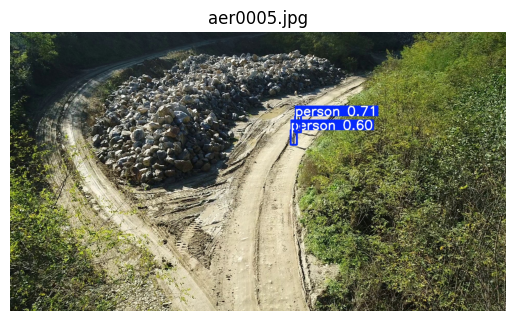

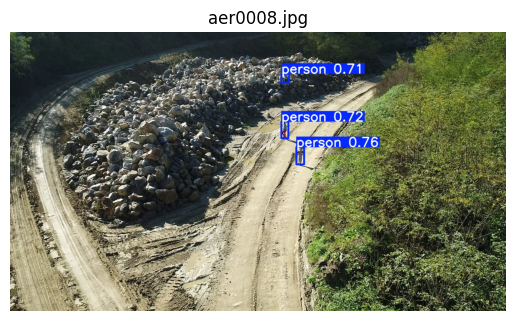

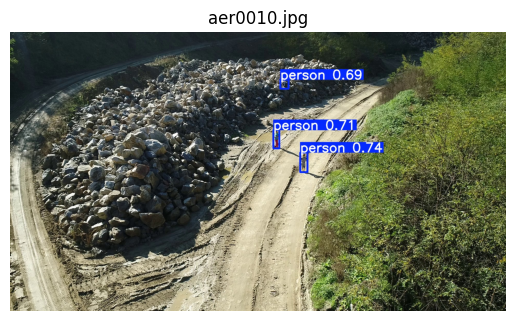

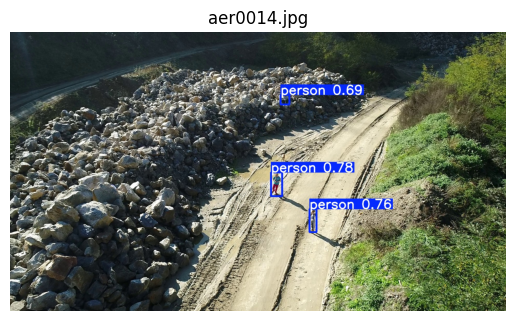

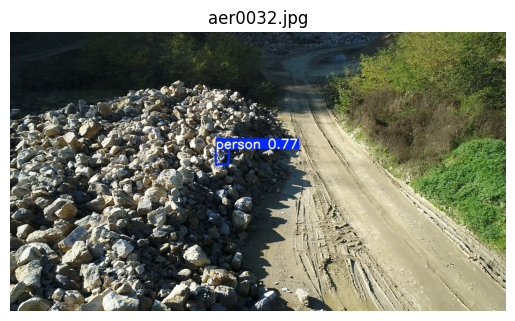

In [20]:
# Directory of annotated images
annotated_dir = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/results/annotated'

# Get all the .jpg files in the directory
annotated_imgs_YOLOv8n = [
  os.path.join(annotated_dir, f)
  for f in os.listdir(annotated_dir)
  if f.lower().endswith('.jpg')
]

# View the first 5 annotated images
for img_path in annotated_imgs_YOLOv8n[:5]:
  img = Image.open(img_path)
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.title(os.path.basename(img_path))

### YOLOv11n

Now let's perform the same procedure for YOLOv11n:

In [12]:
src_yolov11n = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n'
dst_yolov11n = '/content/AERALIS_YOLOv11n_local'  # is now on the local VM, NOT on drive

# If the destination folder already exists, I delete it
if os.path.exists(dst_yolov11n):
  shutil.rmtree(dst_yolov11n)

# Recursive copy of ENTIRE folder (and subfolders)
shutil.copytree(src_yolov11n, dst_yolov11n)
print("Copy completed:", os.path.exists(dst_yolov11n))

Copy completed: True


In [20]:
!df -h / # It shows the total, used and free space on the root (/) of the Colab VM.

# Avail column: space still available for your files.

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   66G   48G  59% /


In [21]:
# Show space used by your local folder
!du -sh /content/AERALIS_YOLOv11n_local

6.5G	/content/AERALIS_YOLOv11n_local


In [22]:
# Show space occupied by various folders in /content/.
!du -h --max-depth=1 /content/

140K	/content/.config
6.5G	/content/AERALIS_YOLOv8n_local
du: cannot access '/content/drive/.Encrypted/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV': No such file or directory
58G	/content/drive
6.5G	/content/AERALIS_YOLOv11n_local
27M	/content/runs_finetune
1.6G	/content/runs_infer
55M	/content/sample_data
72G	/content/


In [21]:
# YAML dataset (edit routes)
data_yaml_yolov11n = """
train: /content/AERALIS_YOLOv11n_local/train/images
val:   /content/AERALIS_YOLOv11n_local/val/images
test:  /content/AERALIS_YOLOv11n_local/test/images

nc: 1
names: ['person']
"""

with open('data.yaml', 'w') as f:
  f.write(data_yaml_yolov11n)

In [24]:
# Upload the pre-trained model we want to use as a starting point

model_YOLOv11n = YOLO('yolo11n.pt') # it is the model that will be fine-tuned on the custom dataset

In [22]:
# To see the available GPU
print(torch.cuda.is_available()) # True = you have GPU --> if False then use device='cpu'

if torch.cuda.is_available():
  print("GPU name:", torch.cuda.get_device_name(0)) # Name of GPU

# If True and at least 1, you can use device=0.
# If you don't have GPU: use device='cpu' (much slower).
# Locally (not Colab): check with nvidia-smi from terminal.

True
GPU name: NVIDIA L4


In [26]:
# Fine‑tuning
results_YOLOv11n = model_YOLOv11n.train(
  data='data.yaml',
  epochs=100,
  imgsz=640,
  batch=24,
  patience=20,
  workers=2,
  device=0,
  project='runs_finetune',
  name='person_yolov11n',
  seed=42,
  deterministic=True,
)

Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_yolov11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

#### First Evaluation YOLOv11n

Weight access code:

In [23]:
# Load the best weights from drive
weights_path_YOLOv11n = "/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights/best.pt"

assert os.path.exists(weights_path_YOLOv11n), f"File not found: {weights_path_YOLOv11n}"
model_YOLOv11n = YOLO(weights_path_YOLOv11n)

Again, we evaluate on the **TEST** split and report:
- **Precision (P)**: fraction of predicted positives that are correct.
- **Recall (R)**: fraction of ground-truth objects retrieved.
- **F1-score**: harmonic mean of P and R (computed at the chosen thresholds).
- **mAP@0.5**: AP at IoU ≥ 0.5.
- **mAP@0.5:0.95**: AP averaged over IoU thresholds 0.50:0.95 (stricter, localization-sensitive).

*Important:* P/R/F1 depend on the **confidence/IoU thresholds** used at evaluation time, while **mAP is threshold-agnostic** (area under the PR curve).

In [24]:
# Evaluates the trained model using the TEST SET defined in data.yaml
metrics_YOLOv11n = model_YOLOv11n.val(data='data.yaml', split='test', plots=True)
print("mAP50-95:", float(metrics_YOLOv11n.box.map),
      " mAP50:", float(metrics_YOLOv11n.box.map50),
      " P:", float(metrics_YOLOv11n.box.mp),
      " R:", float(metrics_YOLOv11n.box.mr))
F1 = 2 * float(metrics_YOLOv11n.box.mp) * float(metrics_YOLOv11n.box.mr) / (
     float(metrics_YOLOv11n.box.mp) + float(metrics_YOLOv11n.box.mr) + 1e-9)
print("F1:", round(F1, 4))

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3610.5±1847.4 MB/s, size: 1636.4 KB)
val: Scanning /content/AERALIS_YOLOv11n_local/test/labels... 544 images, 79 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 544/544 1589.4it/s 0.3s
val: New cache created: /content/AERALIS_YOLOv11n_local/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 5.6it/s 6.1s
                   all        544       1443      0.889      0.774      0.865      0.472
Speed: 0.3ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val4
mAP50-95: 0.47183912224885605  mAP50: 0.8647890267905454  P: 0.8886741317819767  R: 0.7744764708030419
F1: 0.8277


**YOLOv11n – TEST results (default thresholds)**  
- P=0.889, R=0.774, F1=0.828, mAP@0.5=0.865, mAP@0.5:0.95=0.472  
- **Interpretation:** Higher **P** with similar **R** compared to v8n; slightly better F1 and **mAP@0.5:0.95=0.466** consistent with the 640px v11n backbone.
- The "Speed" line (≈1.5 ms infer/img on L4) is a **GPU benchmark**, not representative of Jetson Nano runtime.

*Note: these values were calculated using the Ultralytics default thresholds (≈ conf=0.25, iou=0.70).*

Similarly, as with YOLOv8n, let's perform inference on all images in the folder, and save the annotated images (i.e., the original images with the bounding boxes drawn on them) into a directory:

In [25]:
#  Inference (practical use of the fine-tuned model)

# Performs inference on one or more images, or on a video, by specifying the path in the source parameter.
# conf=0.25 → Confidence threshold for considering a detection valid.
preds_YOLOv11n = model_YOLOv11n.predict(
  source='/content/AERALIS_YOLOv11n_local/test/images',
  conf=0.25,
  iou=0.70,
  verbose=False, # disable on-screen printing
  save=True, save_txt=True, save_conf=True,
  exist_ok=True,
  project='/content/runs_infer', name='yolov11n_test',
  device=0 if torch.cuda.is_available() else 'cpu'
)
out_dir = '/content/runs_infer/yolov11n_test'

# Too many images to show!
# for result in preds_YOLOv11n:
#    result.show() # displays the predictions (eventually you can also save them)

Results saved to /content/runs_infer/yolov11n_test
440 labels saved to /content/runs_infer/yolov11n_test/labels


We use the same thresholds here as in evaluation so deployment matches what we measured.

In [26]:
# Create folders on Google Drive (first time only):
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/results/annotated

In [29]:
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights

In [27]:
# Copy annotated images:
!cp -r /content/runs_infer/yolov11n_test/* /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/results/annotated/

In [30]:
# Copy the best weights (best.pt) after training:
!cp /content/runs_finetune/person_yolov11n/weights/best.pt /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights/best.pt

Access code for annotated images:

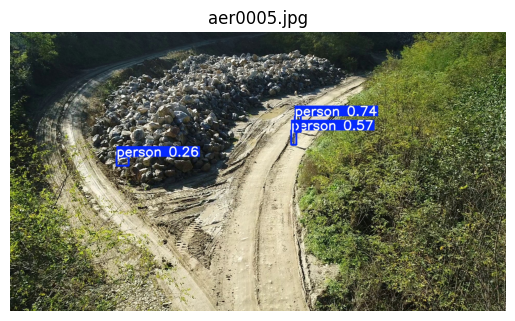

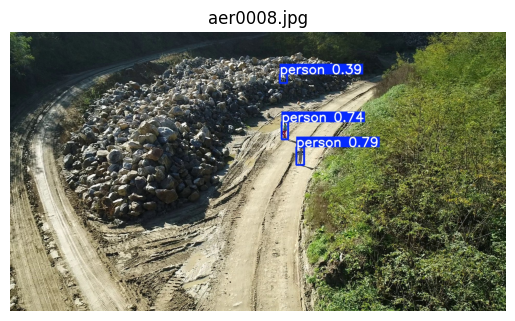

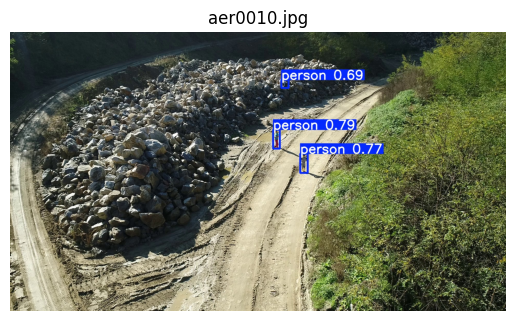

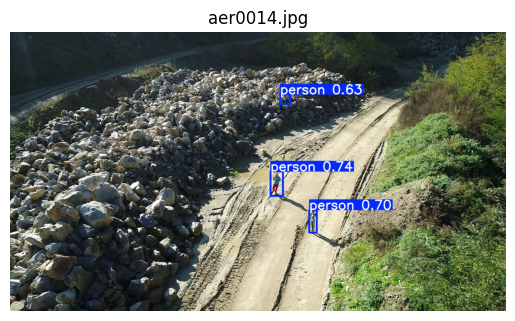

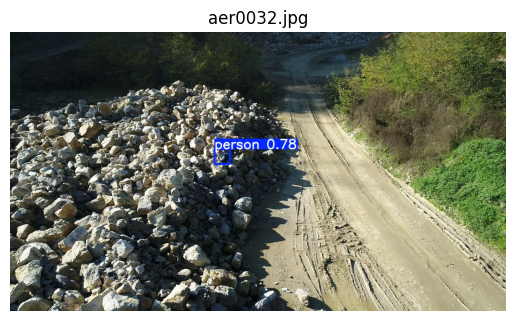

In [28]:
# Directory of annotated images
annotated_dir = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/results/annotated'

# Get all the .jpg files in the directory
annotated_imgs_YOLOv11n = [
  os.path.join(annotated_dir, f)
  for f in os.listdir(annotated_dir)
  if f.lower().endswith('.jpg')
]

# View the first 5 annotated images
for img_path in annotated_imgs_YOLOv11n[:5]:
  img = Image.open(img_path)
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.title(os.path.basename(img_path))

# Evaluation

In [29]:
def dump_metrics_json(path, m, f1):
  data = {
      "map50_95": float(m.box.map),
      "map50": float(m.box.map50),
      "precision": float(m.box.mp),
      "recall": float(m.box.mr),
      "f1": float(f1),
  }
  with open(path, "w") as f:
      json.dump(data, f, indent=2)

Let's now view the metrics of the two models and compare them:

We find the **mean precision** with _.mp_ and the **mean recall** with _.mr_ so that we can then calculate the **F1-score**:

In [30]:
# Get mean precision and recall
precision_v8n = float(metrics_YOLOv8n.box.mp)
recall_v8n = float(metrics_YOLOv8n.box.mr)
precision_v11n = float(metrics_YOLOv11n.box.mp)
recall_v11n = float(metrics_YOLOv11n.box.mr)

# F1 score calculation
f1_yolov8n = 2 * (precision_v8n * recall_v8n) / (precision_v8n + recall_v8n + 1e-9)
f1_yolov11n = 2 * (precision_v11n * recall_v11n) / (precision_v11n + recall_v11n + 1e-9)

In [31]:
# after calculating f1_yolov8n / f1_yolov11n:
dump_metrics_json("metrics_yolov8n.json", metrics_YOLOv8n, f1_yolov8n)
dump_metrics_json("metrics_yolov11n.json", metrics_YOLOv11n, f1_yolov11n)

To visually compare the performance of the two fine-tuned models (YOLOv8n and YOLOv11n) on the test set, we extract their main evaluation metrics including mAP@ 0.5, mAP@ 0.5:0.95, Precision, Recall, and F1-score, and generate a comparative bar plot. \
This helps in quickly identifying which model performs better across different criteria.

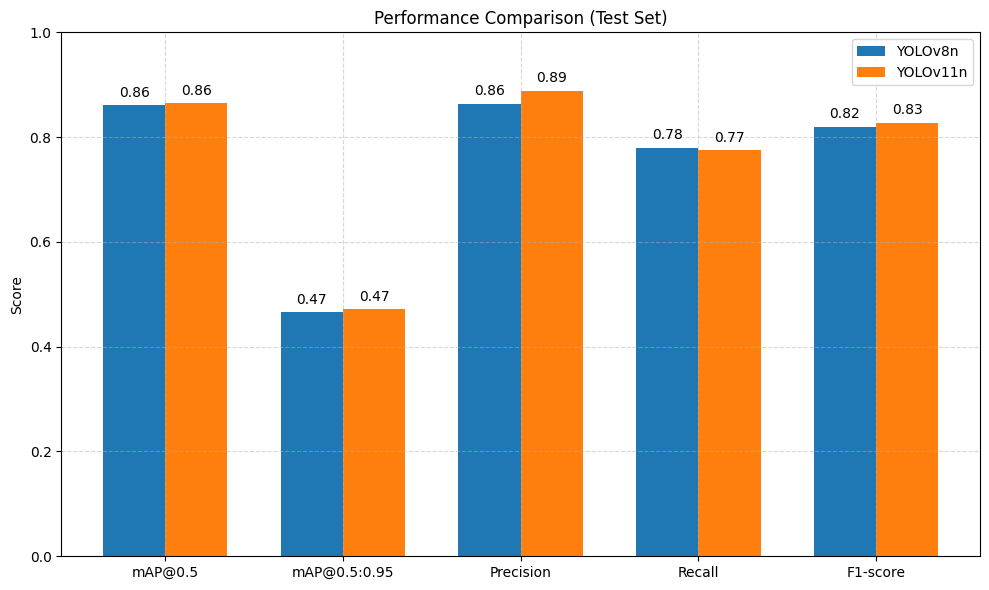

In [32]:
# Extraction of key metrics from both models
metrics = {
  'YOLOv8n': {
    'mAP@0.5': float(metrics_YOLOv8n.box.map50),
    'mAP@0.5:0.95': float(metrics_YOLOv8n.box.map),
    'Precision': float(metrics_YOLOv8n.box.mp),
    'Recall': float(metrics_YOLOv8n.box.mr),
    'F1-score': float(f1_yolov8n),
  },
  'YOLOv11n': {
    'mAP@0.5': float(metrics_YOLOv11n.box.map50),
    'mAP@0.5:0.95': float(metrics_YOLOv11n.box.map),
    'Precision': float(metrics_YOLOv11n.box.mp),
    'Recall': float(metrics_YOLOv11n.box.mr),
    'F1-score': float(f1_yolov11n),
  }
}

# Labels and values
labels = list(metrics['YOLOv8n'].keys())
y8n = [metrics['YOLOv8n'][k] for k in labels]
y11n = [metrics['YOLOv11n'][k] for k in labels]

# Bar Plot
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, y8n, width, label='YOLOv8n')
bars2 = ax.bar(x + width/2, y11n, width, label='YOLOv11n')

ax.set_ylabel('Score')
ax.set_title('Performance Comparison (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.0)

# Notes above the bars
for bar in bars1 + bars2:
  yval = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Comparison: YOLOv8n vs YOLOv11n (TEST, imgsz=640, conf≈0.25, IoU≈0.70)**:

- **YOLOv8n**: P=**0.864**, R=**0.780**, F1=**0.820**, mAP@0.5=**0.861**, mAP@0.5:0.95=**0.466**

- **YOLOv11n**: P=**0.889**, R=**0.774**, F1=**0.828**, mAP@0.5=**0.865**, mAP@0.5:0.95=**0.472**

**How to read this**:

- **Overall performance**: YOLOv11n gives a small but consistent edge on aggregate metrics: **+0.004 mAP@0.5**, **+0.006 mAP@0.5:0.95**, **+0.008 F1**.

- **Precision vs. recall**: the main gain is **Precision** (**+0.025**) with **almost unchanged Recall** (**-0.006**). In low-crowd scenes this usually means **fewer false positives** at similar coverage.

- **Localization**: the slight bump in **mAP@0.5:0.95** suggests **marginally better localization/robustness** across IoU thresholds.

- **Effect size**: differences **are ~1 percentage point** absolute real but **not transformative**. In practice the models are close;


We will choose **YOLOv11n** since our priority is **to reduce false alarms**.

_Note: results are computed on the **same test set** (544 images, 1,443 objects) using **Ultralytics default evaluation thresholds**, providing a standard, reproducible reference.YOLOv8n: P=0.864, R=0.780, F1=0.820, mAP@0.5=0.861, mAP@0.5:0.95=0.466_

# Preparing models for Jetson Nano

When we have the .pt file on the PC, we could:
- Upload it to the Jetson Nano,
- Convert it to ONNX/TensorRT if you need it for optimization,
- Use it with the PyTorch/Ultralytics version on any computer.

In this section, we will prepare the models best_yolov8n.pt and best_yolov11n.pt so that they can be used on the Jetson Nano. \
Let's clarify a few things:

**ONNX** (*Open Neural Network Exchange*) \
ONNX is a universal deep learning model format that allows exporting models from PyTorch, TensorFlow, Keras, and others. \
It enables running models across different platforms using specialized inference tools.

It is an intermediate format: it is not meant for direct inference, but to transfer the model to an optimized inference engine.

**TensorRT** (*NVIDIA AI Accelerator*) \
TensorRT is an optimized inference library by NVIDIA, designed specifically for GPUs and Jetson devices. It is significantly faster than PyTorch or TensorFlow for inference and works best with models converted to _.engine_ format (derived from _.onnx_).

It uses techniques such as:
- Reduced precision (FP16, INT8)
- Layer fusion
- Runtime optimization

It is designed to maximize performance on Jetson devices like the Jetson Nano.

First, we export to .onnx directly on Colab. If there are compatibility or library issues, we will use a different approach and export _.onnx_ directly on Jetson.

In [ ]:
# Create folders on Google Drive (first time only):
!mkdir -p /content/drive/MyDrive/projectUPV/exported_models

In [ ]:
# Save directory on Google Drive
drive_export_dir = "/content/drive/MyDrive/projectUPV/exported_models"
os.makedirs(drive_export_dir, exist_ok=True)

# List of models to export
models_to_export = [
  {"name": "YOLOv8n", "pt_path": "/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best_yolov8n.pt"},
  {"name": "YOLOv11n", "pt_path": "/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights/best_yolov11n.pt"},
]

# Export and save loop
for model_info in models_to_export:
  name = model_info["name"]
  pt_path = model_info["pt_path"]

  print(f"Exporting {name} from {pt_path}...")

  # Load the template
  model = YOLO(pt_path)

  # Export to ONNX
  exported = model.export(format="onnx", imgsz=640, opset=12, dynamic=False)

  onnx_path = exported
  print(f"Exported ONNX file: {onnx_path}")

  # Copy to Drive while retaining the name generated by Ultralytics
  os.makedirs(drive_export_dir, exist_ok=True)
  drive_dst = os.path.join(drive_export_dir, os.path.basename(onnx_path))
  shutil.copy2(onnx_path, drive_dst)
  print(f"ONNX saved to Drive: {drive_dst}")

Exporting YOLOv8n from /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best_yolov8n.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best_yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success ✅ 2.3s, saved as '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best_yolov8n.onnx' (11.6 MB)

Export complete (2.6s)
Results saved to /content/drive/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV/datasets/AERALIS_YOLOv8n/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best_yolov8n.onnx imgsz=640  
Validate:   

**trtexec** is a command line tool included in TensorRT. It is used to:
- Convert _.onnx_ models into optimized _.engine_ models (TensorRT format)
- Perform benchmarks (performance tests) on _.engine_ models

**Quantization** \
Quantization is a technique that reduces the numerical precision of a model's weights and activations. By reducing precision:
- the model takes up less memory (RAM and VRAM)
- the model runs faster
- but it may lose some accuracy (usually minimal)

The Jetson Nano natively supports FP16 via GPU (CUDA), which allows you to speed up the model on the Jetson Nano and save memory.

We will now transfer the test set and the two models converted to .onnx to Jetson Nano in order to check performance.
Next, we will convert these models from .onnx to .engine using the command:

In [ ]:
# /usr/src/tensorrt/bin/trtexec --onnx=best_yolov8n.onnx --saveEngine=best_yolov8n.engine --fp16
# /usr/src/tensorrt/bin/trtexec --onnx=best_yolov11n.onnx --saveEngine=best_yolov11n.engine --fp16

# Nel caso il Jetson non supportasse --fp16, rimuovi --fp16 oppure sostituiscilo con --int8

We then apply:

In [ ]:
# trtexec --loadEngine=best_yolov8n.engine --batch=1
# trtexec --loadEngine=best_yolov11n.engine --batch=1

to perform a synthetic benchmark test, which immediately gives you:

- Average and maximum latency
- FPS (frames per second)
- Throughput

It does not perform inference on real images but only serves to verify the raw speed of the TensorRT engine.

We obtain the output shape from the .onnx models:

In [ ]:
!pip install onnx

In [ ]:
import onnx

In [ ]:
# Upload the .onnx file

model_path_yolov8n = "/content/drive/MyDrive/projectUPV/exported_models/best_yolov8n.onnx"
model_path_yolov11n = "/content/drive/MyDrive/projectUPV/exported_models/best_yolov11n.onnx"
onnx_model_yolov8n = onnx.load(model_path_yolov8n)
onnx_model_yolov11n = onnx.load(model_path_yolov11n)

# Extract info on outputs
output_info_yolov8n = onnx_model_yolov8n.graph.output
print("YOLOv8n \n")
for out in output_info_yolov8n:
  name = out.name
  shape = [dim.dim_value for dim in out.type.tensor_type.shape.dim]
  print(f"Output name: {name}, shape: {shape}")


output_info_yolov11n = onnx_model_yolov11n.graph.output
print("YOLOv11n \n")
for out in output_info_yolov11n:
  name = out.name
  shape = [dim.dim_value for dim in out.type.tensor_type.shape.dim]
  print(f"Output name: {name}, shape: {shape}")

YOLOv8n 

Output name: output0, shape: [1, 5, 8400]
YOLOv11n 

Output name: output0, shape: [1, 5, 8400]


This means that the exported ONNX has dynamic shapes (batch, num_detections, elements).

Script to run on Jetson to run the model on the test set: